In [3]:
import tiktoken
import glob
import os
import re
import sys
import pandas as pd

import matplotlib.pyplot as plt
from helpers import set_paper_style, save_plots
sys.path.append("../../")
os.getcwd()
from dotenv import load_dotenv
load_dotenv()
set_paper_style()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
MODELS = ["gemini2point5flash", "gpto4mini"]

## Time Taken

In [6]:
def get_round_time(data) -> dict:
    time_dict = {}
    for r in range(0, 10):
        pattern = rf"Execution Time of Negotiation for round {r}:\s*([0-9]+\.[0-9]+)"
        # Search using regex
        match = re.search(pattern, data)
        
        # Extract the value
        if match:
            value = round(float(match.group(1)),2)
            time_dict[r] = value
        else:
            print("\t No match found.")
            continue
    return time_dict

In [7]:
def generate_timelog_data(model_name = "gemini2point5flash", method="aggressive"):
    folder_name = f"../../data/conv-trs/multi-agent/results/prototype_early_stopping/"
    print(folder_name)
    rows =[]
    for file in glob.glob(f"{folder_name}/{model_name}/logs/*.txt"):
        match = re.search(r"log_(.*)\.txt", file)
        if match:
            config_name = match.group(1)
            print(config_name)
        f = open(file)
        data = f.read()
        time_dict = get_round_time(data)
        row = {"config": config_name}
        row.update(time_dict)  # Add all round times
        rows.append(row)
    df = pd.DataFrame(rows)
    round_columns = [i for i in range(30)]

    # # Sum the round columns row-wise and store in a new column
    # df["total_time"] = df[round_columns].sum(axis=1)

    # df.to_csv(f"../../data/conv-trs/multi-agent/results/prototype_early_stopping/{model_name}/time_log.csv", index=False)
    return df

In [20]:
def plot_fig():
    # Identify round columns
    round_columns = [i for i in range(10)]
    # Plot
    # plt.figure(figsize=(12, 8))
    plt.figure(figsize=(6, 4))
    for model in MODELS:
        df = generate_timelog_data(model)   
        # Drop rounds where all values are NaN
        valid_rounds = df[round_columns].dropna(axis=1, how='all')
        
        # Calculate mean per round (NaNs automatically ignored)
        avg_per_round = valid_rounds.mean()
        if "gpt" in model.lower():
            model = "GPTo4Mini"
        else:
            model = model.title()

        plt.plot(round_columns, avg_per_round.values, marker='o', label=model)
    # plt.title("Average Execution Time per Round (Valid Rounds Only)")
    plt.xlabel("Round Number")
    plt.ylabel("Avg. Exec. Time (s)")
    # plt.legend(title="Model", fontsize=20, title_fontsize=22, loc="upper right")
    plt.legend(
    title="Model",
    fontsize=20,
    title_fontsize=22,
    loc="upper left",  # position relative to bbox
    bbox_to_anchor=(1.02, 1),  # moves it outside the axes
    prop={"weight": "bold"}  # bold legend text
)
    plt.xticks(round_columns)
    plt.tight_layout()
    save_plots(file_name="time_taken", subfolder="costs",
               extensions=["pdf", "png"],
               copy_to_paper=True,
               paper_location=os.getenv("PAPER_LOCATION"))
    plt.show()

../../data/conv-trs/multi-agent/results/prototype_early_stopping/
c_p_143_pop_high_hard
c_p_113_pop_high_medium
c_p_116_pop_high_hard
c_p_15_pop_high_hard
c_p_196_pop_medium_hard
c_p_94_pop_high_medium
c_p_130_pop_high_medium
c_p_155_pop_high_hard
c_p_131_pop_high_medium
c_p_162_pop_high_medium
c_p_5_pop_high_hard
../../data/conv-trs/multi-agent/results/prototype_early_stopping/
c_p_143_pop_high_hard
c_p_15_pop_high_hard


/var/folders/gk/1_hpxk0x6bvfh9xs2r_splw40000gn/T/ipykernel_82849/3574856945.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/ashmi/Code/Scripts/phd/travel-crs/tests/multi_ctrs/helpers.py:166: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


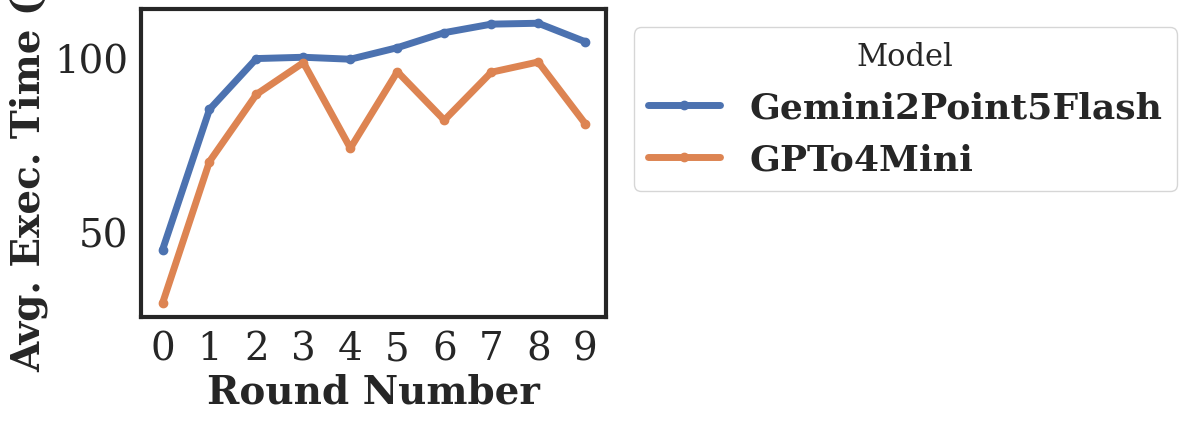

In [21]:
plot_fig()

## API Costs

In [8]:
def calc_api_calls(agents = 3, rounds = 30, queries = 45, initial_feedback = 2, rejection_strategy_method = 2):
    return agents * rounds * queries * initial_feedback * rejection_strategy_method

In [9]:
api_calls = calc_api_calls()

api_calls

16200

In [10]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [11]:
def token_count(file_path):
    f = open(file_path)
    return num_tokens_from_string(f.read(), "o200k_base")
    

In [12]:
def get_total_token_count(model_name):
    file_path = f"../../data/conv-trs/multi-agent/results/prompt_ranking_aggressive/{model_name}/logs/*.txt"
    total_token_count = 0
    for file in glob.glob(file_path):
        total_token_count += token_count(file)
    print(total_token_count)
    return total_token_count

In [13]:
def calculate_gemini_cost(tokens_in_context: int, rate_per_million: float = 0.15) -> float:
    """
    Calculate the cost of tokens in the context window.

    Parameters:
        tokens_in_context (int): Number of tokens in the context window.
        rate_per_million (float): Cost in USD per 1 million tokens (default: 0.15).

    Returns:
        float: Cost in USD.
    """
    # 0.15 USD per 1M tokens in context window
    cost = (tokens_in_context / 1000000) * rate_per_million
    return round(cost, 6)


In [14]:
def calculate_openai_costs (api_call_count, per_call_cost):
    # Input: $1.100 / 1M tokens  Output: $4.400 / 1M tokens
    pass


In [15]:
def model_costs(model_name):
    total_api_calls = calc_api_calls(agents = 3, rounds = 10, queries = 45, initial_feedback = 2, rejection_strategy_method = 2)
    total_token_count = get_total_token_count("gemini2point5flash")
    print(f"Total tokens consumed by {model_name} for {total_api_calls} API calls: {total_token_count}")
    if model_name == "gemini2point5flash":
        api_cost = calculate_gemini_cost(total_token_count)
    else:
        api_cost = calculate_openai_costs (total_token_count)
    print(f"API costs: {api_cost} USD")

In [16]:
model_costs("gemini2point5flash")

3207341
Total tokens consumed by gemini2point5flash for 5400 API calls: 3207341
API costs: 0.481101 USD
